# UCI Heart Disease Notebook

## 1. Import Libraries and Setup

In [14]:
import pandas as pd
import graphviz
import numpy as np
import matplotlib.pyplot as plt
import pydotplus

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown, Image

## 2. Data Loading

In [15]:
def load_data():
    """Fetch the Heart Disease dataset from UCI repository."""
    heart_disease = fetch_ucirepo(id=45)
    features = heart_disease.data.features
    targets = heart_disease.data.targets

    if targets.shape[1] == 1:
        targets.columns = ["target"]

    df = pd.concat([features, targets], axis=1)

    # Convert appropriate columns back to categorical
    categorical_columns = ['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs', 'exang']
    
    for col in categorical_columns:
        if col in df.columns:
            df[col] = df[col].astype('category')

    return df

## 3. Data Types Analysis & Debugging

In [16]:
def debug_data_types():
    """Debug function to check original vs processed data types."""
    df = load_data()
    
    print("Data Types Analysis:")
    print("=" * 50)
    print("All columns and their types:")
    print(df.dtypes)
    
    print(f"\nNumeric columns: {df.select_dtypes(include=['int64', 'float64']).columns.tolist()}")
    print(f"Categorical columns: {df.select_dtypes(include=['object', 'category']).columns.tolist()}")
    
    print(f"\nTotal features: {len(df.columns) - 1}")  # -1 for target
    print(f"Numeric features: {len(df.select_dtypes(include=['int64', 'float64']).columns) - 1}")  # -1 for target
    print(f"Categorical features: {len(df.select_dtypes(include=['object', 'category']).columns)}")
    
    # Show unique values for potential categorical columns
    potential_categorical = ['cp', 'restecg', 'slope', 'ca', 'thal', 'sex', 'fbs', 'exang']
    print(f"\nPotential categorical columns (showing unique values):")
    for col in potential_categorical:
        if col in df.columns:
            unique_vals = sorted(df[col].unique())
            print(f"  {col}: {unique_vals}")
    
    return df

# Call the function to load and debug data types
print("Running data types analysis...")
df_debug = debug_data_types()

Running data types analysis...
Data Types Analysis:
All columns and their types:
age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
target         int64
dtype: object

Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

Total features: 13
Numeric features: 5
Categorical features: 8

Potential categorical columns (showing unique values):
  cp: [1, 2, 3, 4]
  restecg: [0, 1, 2]
  slope: [1, 2, 3]
  ca: [0.0, 1.0, 2.0, 3.0, nan]
  thal: [3.0, 6.0, 7.0, nan]
  sex: [0, 1]
  fbs: [0, 1]
  exang: [0, 1]


## 4. Data Preprocessing

In [17]:
def preprocess_data(df):
    """Prepare features and target + create preprocessing pipeline."""
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    numeric_features = numeric_cols.drop("target") if "target" in numeric_cols else numeric_cols
    categorical_features = df.select_dtypes(include=["object", "category"]).columns

    # Added SimpleImputer to handle missing values
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    X = df.drop("target", axis=1)
    y = df["target"]
    y = np.where(y == 0, 0, 1)
    return X, y, preprocessor

## 5. Distribution Plot

In [18]:
def plot_distribution(y, title="Target Distribution"):
    """Plot the distribution of the target labels."""
    # Ensure y is a Pandas Series
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    counts = y.value_counts().sort_index()
    plt.figure(figsize=(5, 3))
    plt.bar(counts.index.astype(str), counts.values, color="skyblue")
    plt.title(title)
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 6. Class Contribution Comparison

In [19]:
def plot_class_contribution_comparison(y_original, y_train, y_test, test_ratio):
    """Compare class contribution between original dataset and train/test splits."""
    
    # Convert to pandas Series if needed
    if isinstance(y_original, np.ndarray):
        y_original = pd.Series(y_original)
    if isinstance(y_train, np.ndarray):
        y_train = pd.Series(y_train)
    if isinstance(y_test, np.ndarray):
        y_test = pd.Series(y_test)
    
    # Calculate proportions
    original_counts = y_original.value_counts().sort_index()
    train_counts = y_train.value_counts().sort_index()
    test_counts = y_test.value_counts().sort_index()
    
    original_props = (original_counts / len(y_original) * 100).round(2)
    train_props = (train_counts / len(y_train) * 100).round(2)
    test_props = (test_counts / len(y_test) * 100).round(2)
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original dataset
    axes[0].bar(original_counts.index.astype(str), original_props.values, 
                color=['lightcoral', 'lightblue'], alpha=0.8)
    axes[0].set_title(f'Original Dataset\n(Total: {len(y_original)} samples)')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage labels on bars
    for i, (idx, val) in enumerate(original_props.items()):
        axes[0].text(i, val + 1, f'{val}%', ha='center', va='bottom', fontweight='bold')
    
    # Train set
    axes[1].bar(train_counts.index.astype(str), train_props.values, 
                color=['lightcoral', 'lightblue'], alpha=0.8)
    axes[1].set_title(f'Train Set ({int((1-test_ratio)*100)}%)\n(Total: {len(y_train)} samples)')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Percentage (%)')
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for i, (idx, val) in enumerate(train_props.items()):
        axes[1].text(i, val + 1, f'{val}%', ha='center', va='bottom', fontweight='bold')
    
    # Test set
    axes[2].bar(test_counts.index.astype(str), test_props.values, 
                color=['lightcoral', 'lightblue'], alpha=0.8)
    axes[2].set_title(f'Test Set ({int(test_ratio*100)}%)\n(Total: {len(y_test)} samples)')
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('Percentage (%)')
    axes[2].grid(True, axis='y', linestyle='--', alpha=0.7)
    
    for i, (idx, val) in enumerate(test_props.items()):
        axes[2].text(i, val + 1, f'{val}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("Class Distribution Comparison:")
    print("=" * 50)
    comparison_df = pd.DataFrame({
        'Class': original_counts.index,
        'Original (%)': original_props.values,
        'Train (%)': train_props.values,
        'Test (%)': test_props.values,
        'Original Count': original_counts.values,
        'Train Count': train_counts.values,
        'Test Count': test_counts.values
    })
    
    display(comparison_df)
    
    # Calculate and display deviation from original
    print("\nDeviation from Original Distribution:")
    print("=" * 40)
    for class_label in original_counts.index:
        train_dev = train_props[class_label] - original_props[class_label]
        test_dev = test_props[class_label] - original_props[class_label]
        print(f"Class {class_label}:")
        print(f"  Train deviation: {train_dev:+.2f}%")
        print(f"  Test deviation:  {test_dev:+.2f}%")

## 7. Building the Model Pipeline

In [20]:

def build_pipeline(preprocessor, max_depth=None):
    """Construct a pipeline with preprocessing and decision tree."""
    return Pipeline([
        ("preprocess", preprocessor),
        ("classifier", DecisionTreeClassifier(
            max_depth=max_depth, 
            random_state=42,
            criterion='entropy'
        ))
    ])

## 8. Training the Decision Tree Model

In [21]:
def train_model(pipeline, X_train, y_train):
    """Fit the pipeline to training data."""
    pipeline.fit(X_train, y_train.ravel())  # ravel for compatibility with single-column y
    return pipeline

## 9. Evaluating the Model Performance

In [22]:
def evaluate_model(clf, X_test, y_test, title_prefix=""):
    """Evaluate classifier and visualize results."""
    y_pred = clf.predict(X_test)
    display(Markdown(f"### {title_prefix} Classification Report"))
    print(classification_report(y_test, y_pred))
    display(Markdown(f"### {title_prefix} Confusion Matrix"))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.show()

## 10. Suppress stderr when called `graphviz.Source`

In [23]:
import os
import sys
import contextlib

@contextlib.contextmanager
def suppress_stderr():
    """Context to suppress stderr."""
    with open(os.devnull, 'w') as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stderr = old_stderr

## 11. Visualize Decision Tree

In [24]:
def visualize_tree(clf, X_sample, title_prefix=""):
    """Visualize the decision tree using matplotlib and Graphviz."""

    display(Markdown(f"### {title_prefix} Decision Tree Visualization (matplotlib)"))

    # Extract fitted model and preprocessor
    model = clf.named_steps["classifier"]
    preprocess = clf.named_steps["preprocess"]

    # Get the original feature names
    num_features = preprocess.transformers_[0][2]
    cat_features = preprocess.transformers_[1][2]

    # Get the categorical transformer pipeline
    cat_transformer = preprocess.named_transformers_["cat"]
    ohe = cat_transformer.named_steps["encoder"]

    try:
        cat_feature_names = ohe.get_feature_names_out(cat_features)
    except NotFittedError:
        print("Creating feature names from sample data...")
        sample_cat_data = X_sample[cat_features].head(10)
        cat_feature_names = []
        for col in cat_features:
            unique_vals = sample_cat_data[col].unique()
            for val in unique_vals:
                cat_feature_names.append(f"{col}_{val}")
        cat_feature_names = np.array(cat_feature_names)

    # Combine all feature names
    all_feature_names = np.concatenate([num_features, cat_feature_names])

    # Plot tree using matplotlib
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=all_feature_names,
        class_names=["0", "1"],
        filled=True
        # max_depth=3
    )
    plt.title(f"{title_prefix} Decision Tree (matplotlib)", fontsize=16, pad=20)
    plt.show()

    # Graphviz visualization
    display(Markdown(f"### {title_prefix} Decision Tree (Graphviz)"))

    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=all_feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True,
        special_characters=True,
        fontname="Arial"
        # max_depth=3
    )

    # Suppress warnings from Graphviz
    with suppress_stderr():
        graph = graphviz.Source(dot_data)
        image_bytes = graph.pipe(format='png')
        display(Image(image_bytes))

## 12. Run Experiments for Different Test Sizes

In [25]:
def run_experiments(df, test_ratios=[0.1, 0.2, 0.4, 0.6]):
    """Train and evaluate the model for different test sizes."""
    X, y, preprocessor = preprocess_data(df)
    accuracies = []
    depths = []
    models = []

    for ratio in test_ratios:
        display(Markdown(f"## Test Size: {ratio}"))
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=ratio, stratify=y, random_state=42
        )

        # Plot class contribution comparison
        display(Markdown(f"### Class Contribution Analysis"))
        plot_class_contribution_comparison(y, y_train, y_test, ratio)

        # Plot class distribution to validate stratification
        plot_distribution(y, f"Original Dataset Distribution")
        plot_distribution(y_train, f"Train Set Distribution ({int((1-ratio)*100)}%)")
        plot_distribution(y_test, f"Test Set Distribution ({int(ratio*100)}%)")

        pipeline = build_pipeline(preprocessor)
        clf = train_model(pipeline, X_train, y_train)
        acc = clf.score(X_test, y_test)
        depth = clf.named_steps["classifier"].get_depth()

        accuracies.append(acc)
        depths.append(depth)
        models.append(clf)

        evaluate_model(clf, X_test, y_test, title_prefix=f"Test Size {ratio}")
        
        visualize_tree(clf, X_train, title_prefix=f"Test Size {ratio}")

    return models, accuracies, depths

## 13. Max Depth Experiment

In [26]:
def max_depth_experiment(df, test_size=0.2, depths=[None, 2, 3, 4, 5, 6, 7]):
    """Experiment with different max_depth values for decision tree."""
    display(Markdown(f"## Max Depth Experiment (Test Size = {int(test_size*100)}%)"))
    
    X, y, preprocessor = preprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    accuracies = []
    models = []
    
    for d in depths:
        display(Markdown(f"### Max Depth = {d if d is not None else 'None'}"))
        
        # Build pipeline with specific max_depth
        pipeline = build_pipeline(preprocessor, max_depth=d)
        clf = train_model(pipeline, X_train, y_train)
        
        # Evaluate model
        evaluate_model(clf, X_test, y_test, title_prefix=f"Max Depth {d}")
        
        # Visualize tree
        visualize_tree(clf, X_train, title_prefix=f"Max Depth {d}")
        
        # Calculate accuracy
        acc = clf.score(X_test, y_test)
        accuracies.append(acc)
        models.append(clf)
        
        print(f"Max Depth = {d if d is not None else 'None'} → Accuracy = {acc:.4f}")
        print("-" * 50)

    # Plot accuracy vs max_depth
    plt.figure(figsize=(10, 6))
    depth_labels = [str(d) if d is not None else 'None' for d in depths]
    plt.plot(range(len(depths)), accuracies, marker='o', linewidth=2, markersize=8)
    plt.xticks(range(len(depths)), depth_labels)
    plt.title("Accuracy vs Max Depth", fontsize=14)
    plt.xlabel("Max Depth", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create results table
    results_df = pd.DataFrame({
        'max_depth': depth_labels,
        'accuracy': [f"{acc:.4f}" for acc in accuracies]
    })
    
    display(Markdown("### Results Summary"))
    display(results_df)
    
    return models, accuracies

## 14. Main Execution

0: Train/Test = 40/60


## Test Size: 0.6

### Class Contribution Analysis

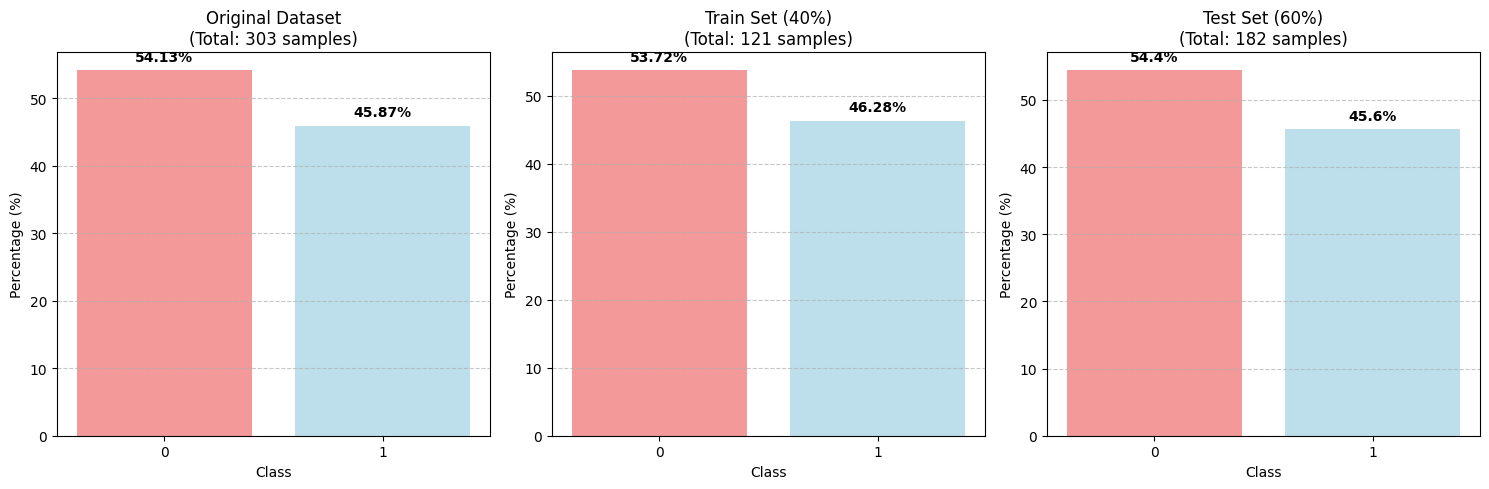

Class Distribution Comparison:


,Class,Original (%),Train (%),Test (%),Original Count,Train Count,Test Count
0,0,54.13,53.72,54.4,164,65,99
1,1,45.87,46.28,45.6,139,56,83



Deviation from Original Distribution:
Class 0:
  Train deviation: -0.41%
  Test deviation:  +0.27%
Class 1:
  Train deviation: +0.41%
  Test deviation:  -0.27%


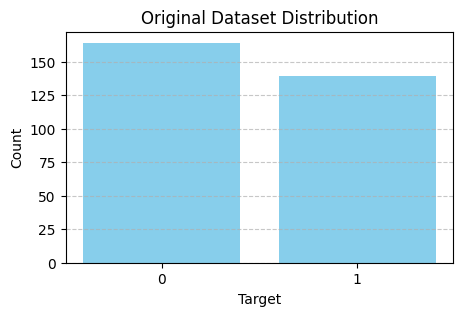

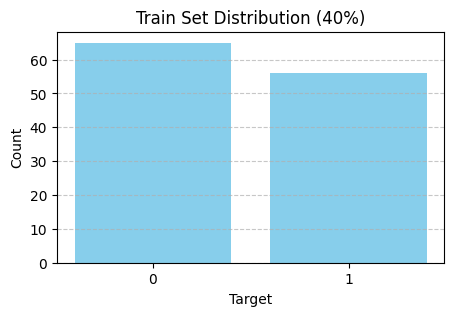

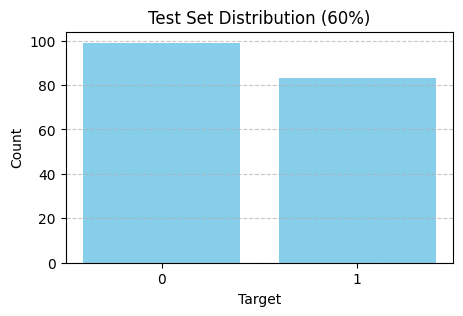

### Test Size 0.6 Classification Report

              precision    recall  f1-score   support

           0       0.79      0.71      0.74        99
           1       0.69      0.77      0.73        83

    accuracy                           0.74       182
   macro avg       0.74      0.74      0.74       182
weighted avg       0.74      0.74      0.74       182



### Test Size 0.6 Confusion Matrix

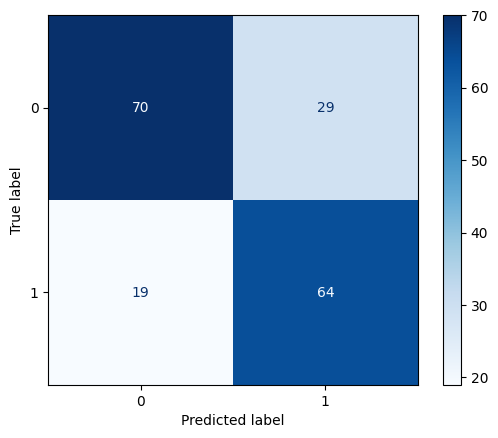

### Test Size 0.6 Decision Tree Visualization (matplotlib)

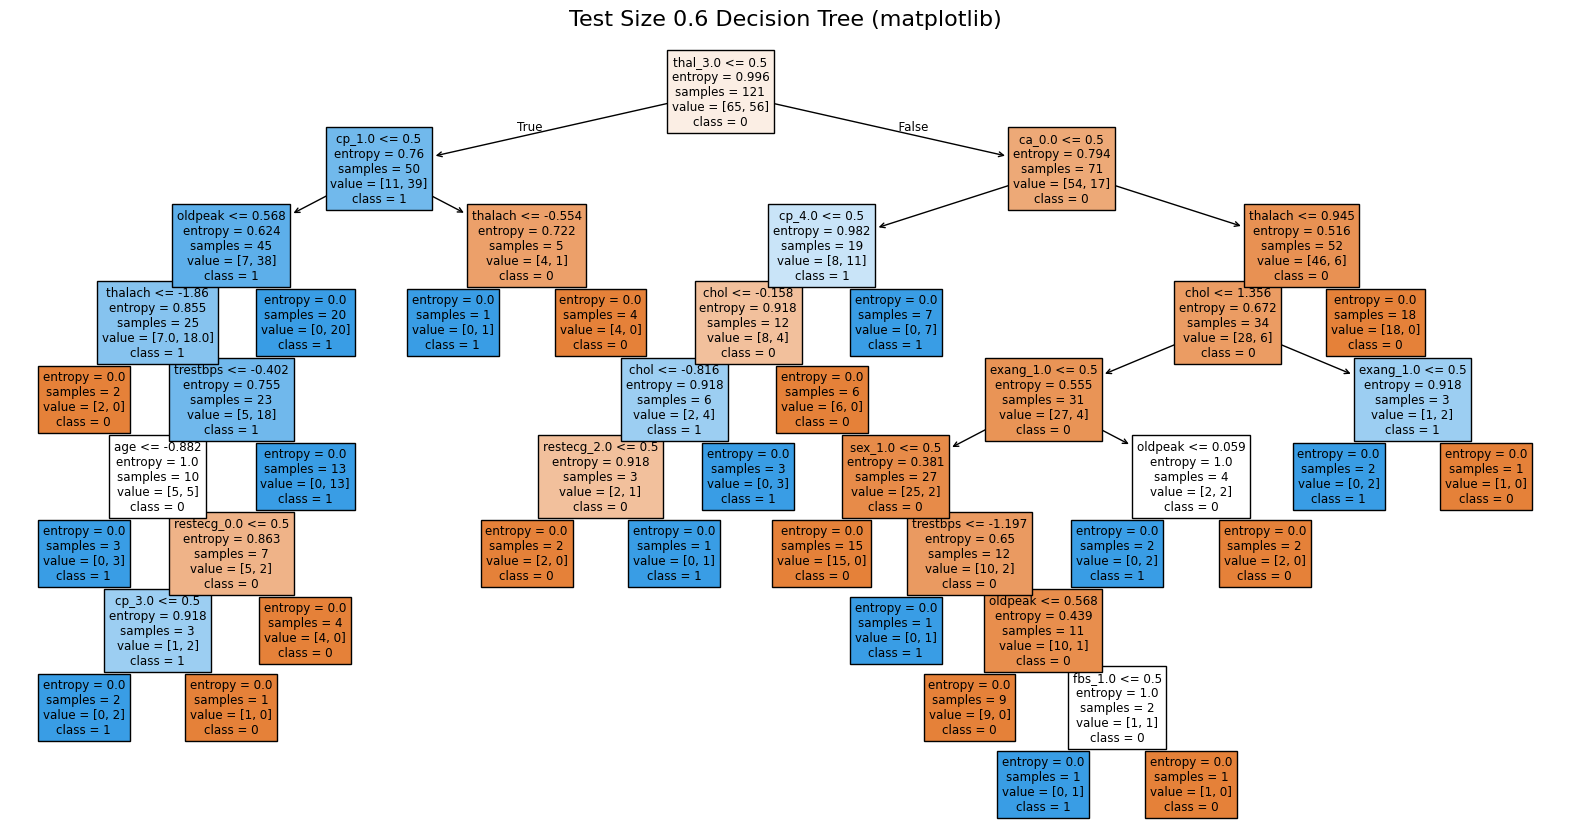

### Test Size 0.6 Decision Tree (Graphviz)

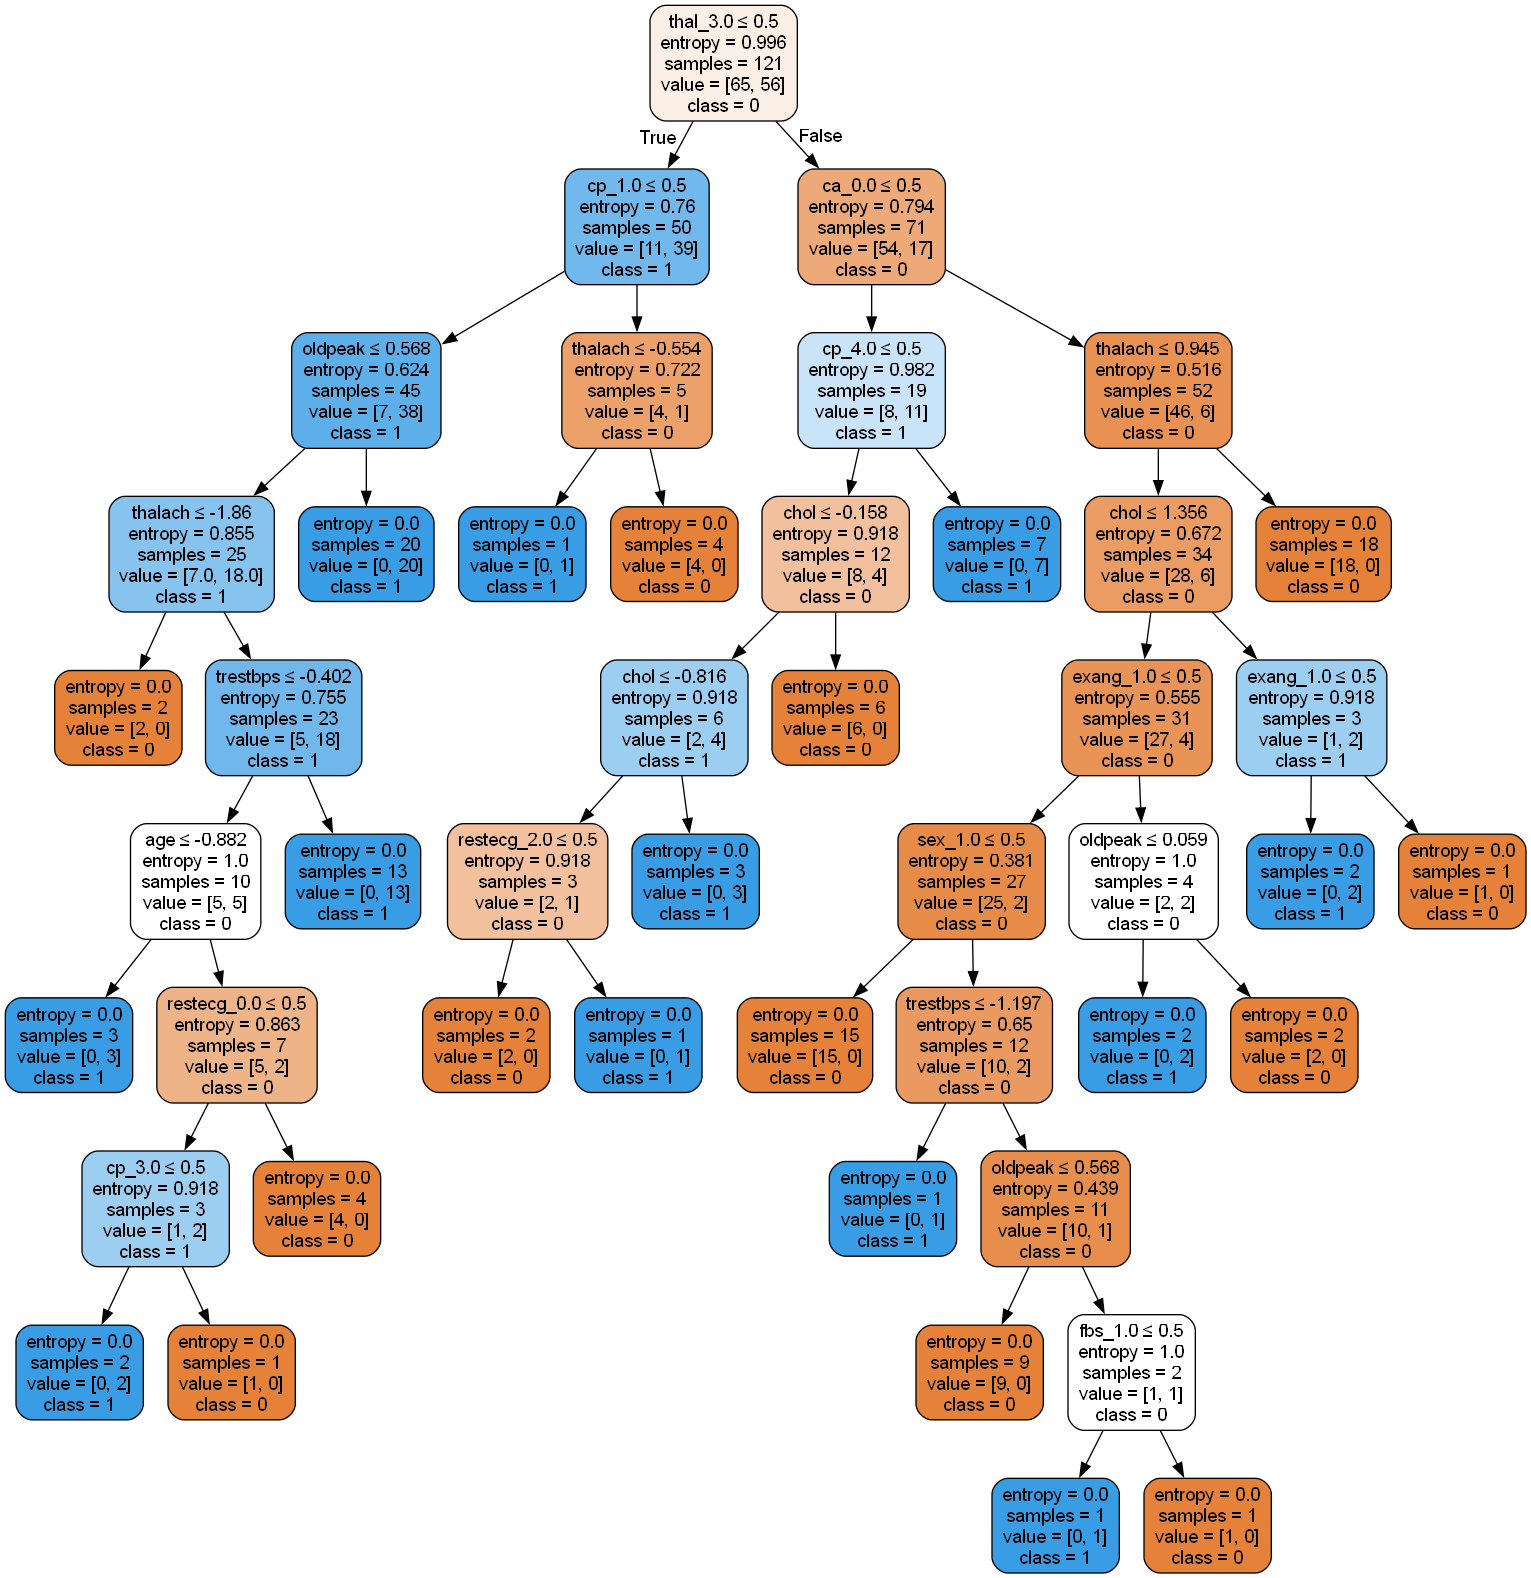

1: Train/Test = 60/40


## Test Size: 0.4

### Class Contribution Analysis

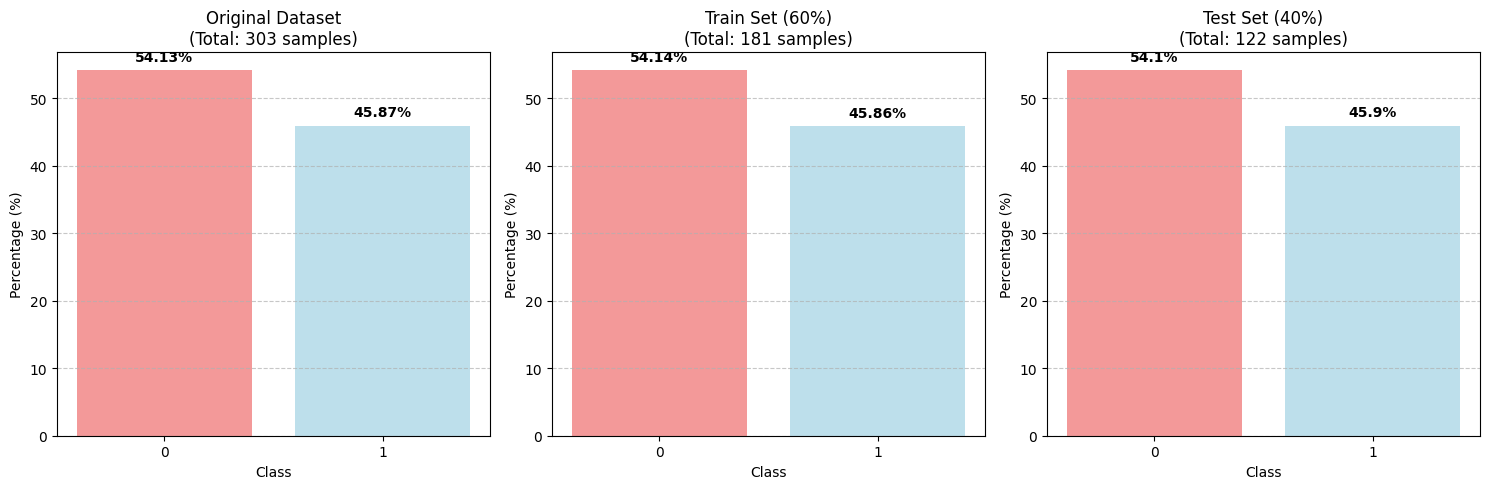

Class Distribution Comparison:


,Class,Original (%),Train (%),Test (%),Original Count,Train Count,Test Count
0,0,54.13,54.14,54.1,164,98,66
1,1,45.87,45.86,45.9,139,83,56



Deviation from Original Distribution:
Class 0:
  Train deviation: +0.01%
  Test deviation:  -0.03%
Class 1:
  Train deviation: -0.01%
  Test deviation:  +0.03%


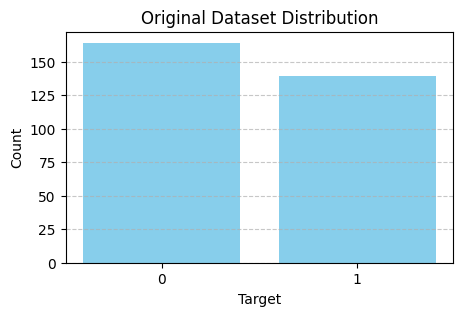

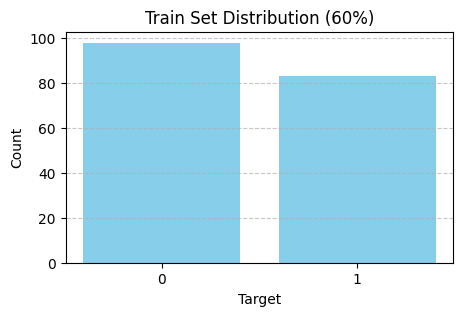

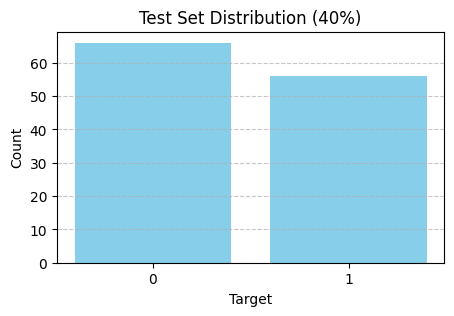

### Test Size 0.4 Classification Report

              precision    recall  f1-score   support

           0       0.80      0.71      0.75        66
           1       0.70      0.79      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.75      0.75      0.75       122



### Test Size 0.4 Confusion Matrix

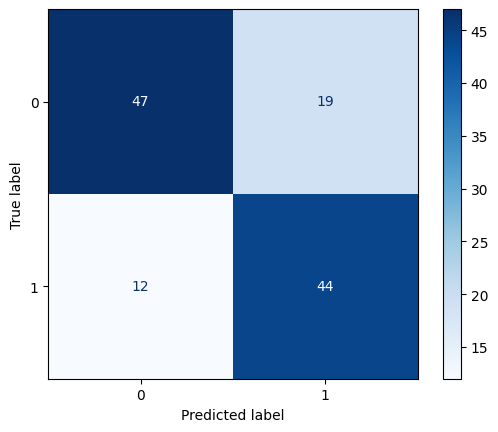

### Test Size 0.4 Decision Tree Visualization (matplotlib)

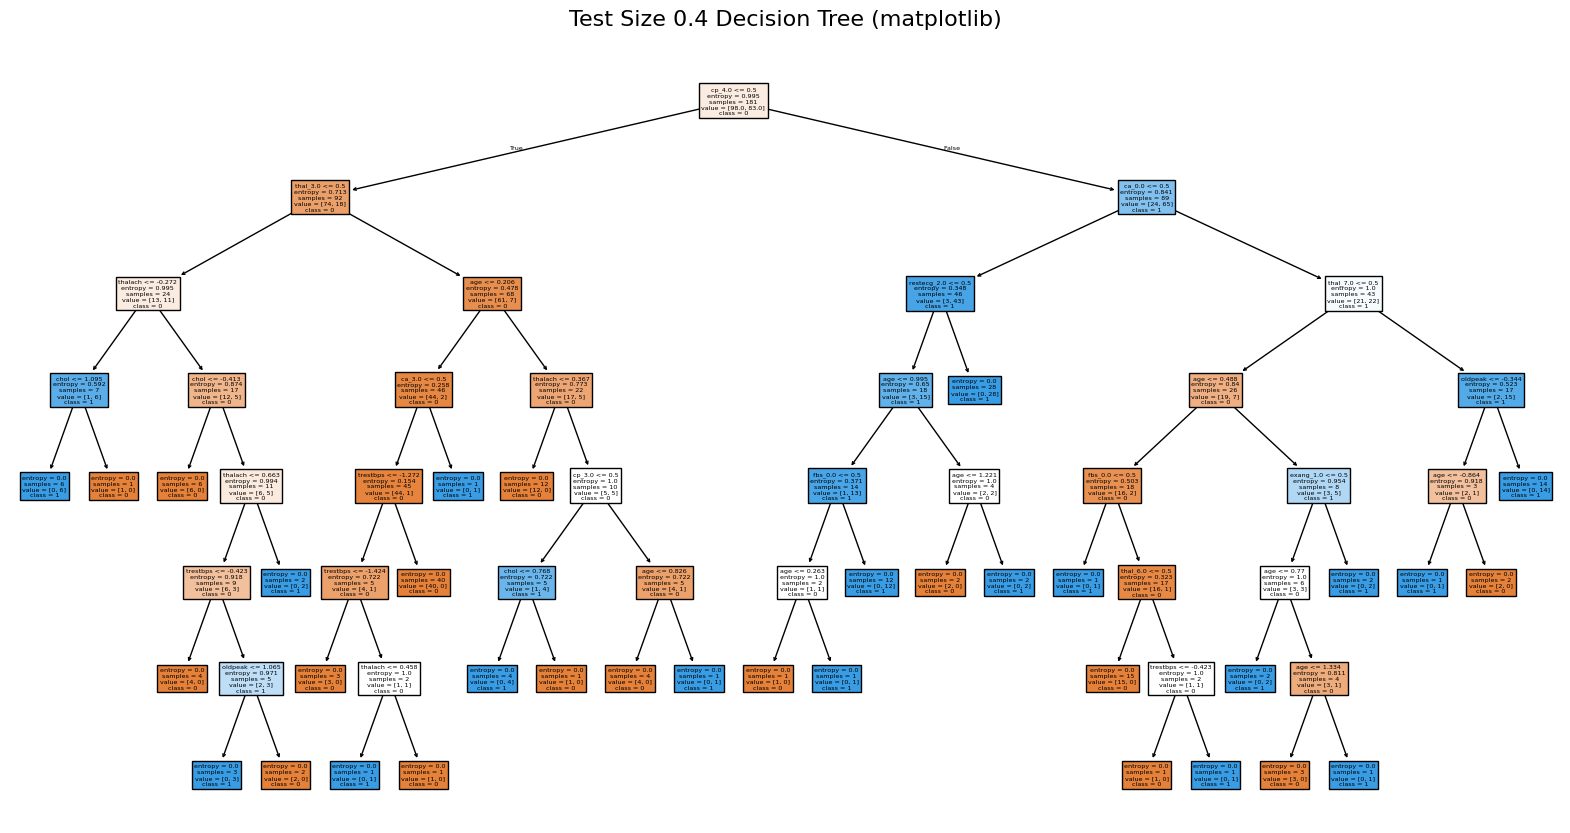

### Test Size 0.4 Decision Tree (Graphviz)

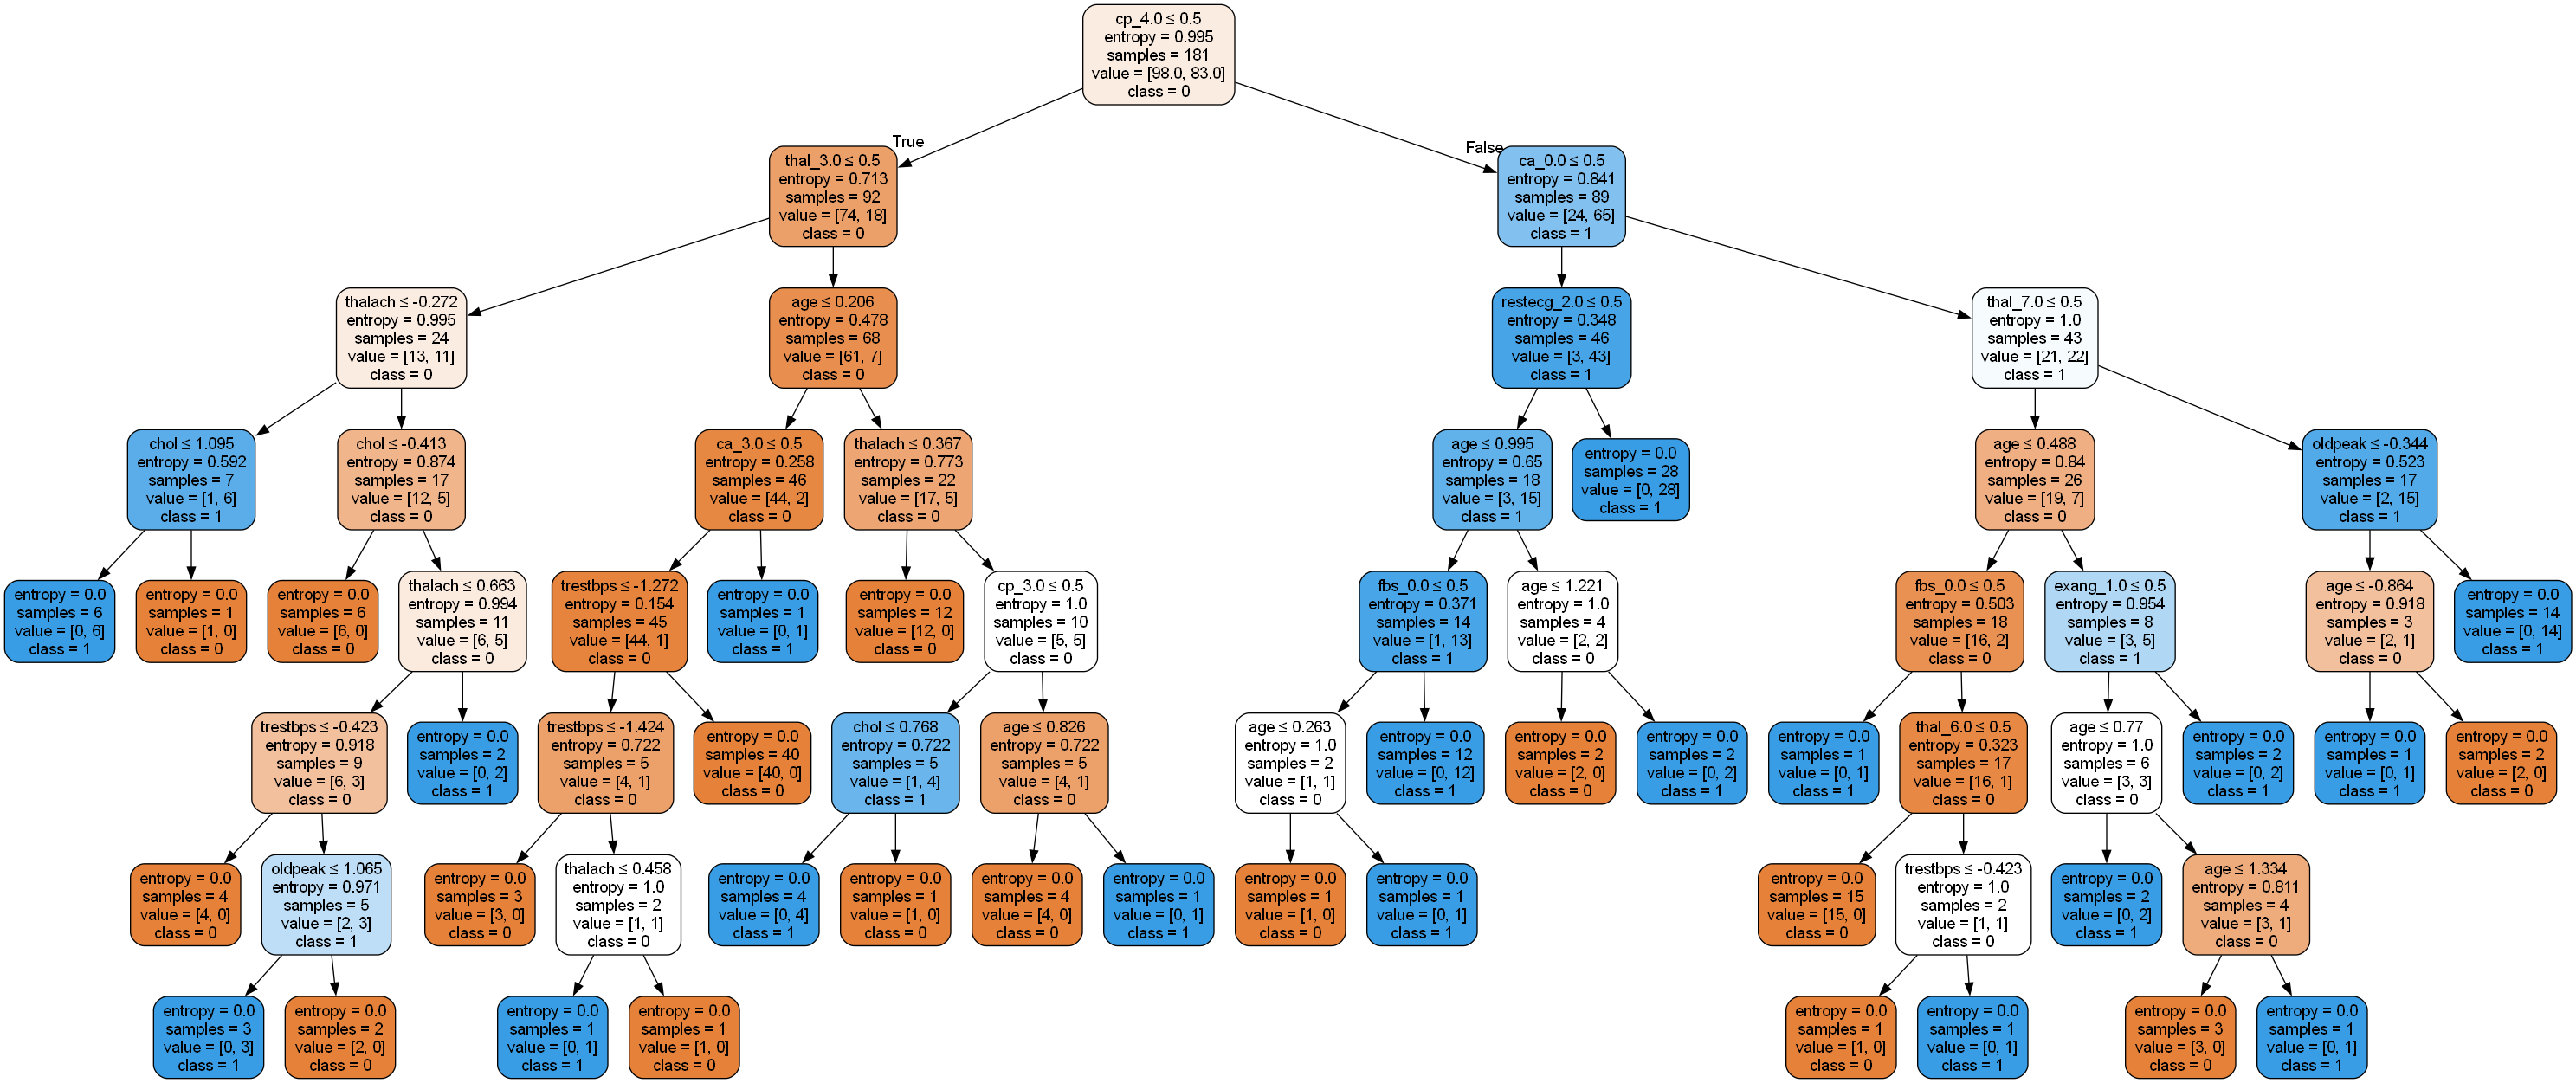

2: Train/Test = 80/20


## Test Size: 0.2

### Class Contribution Analysis

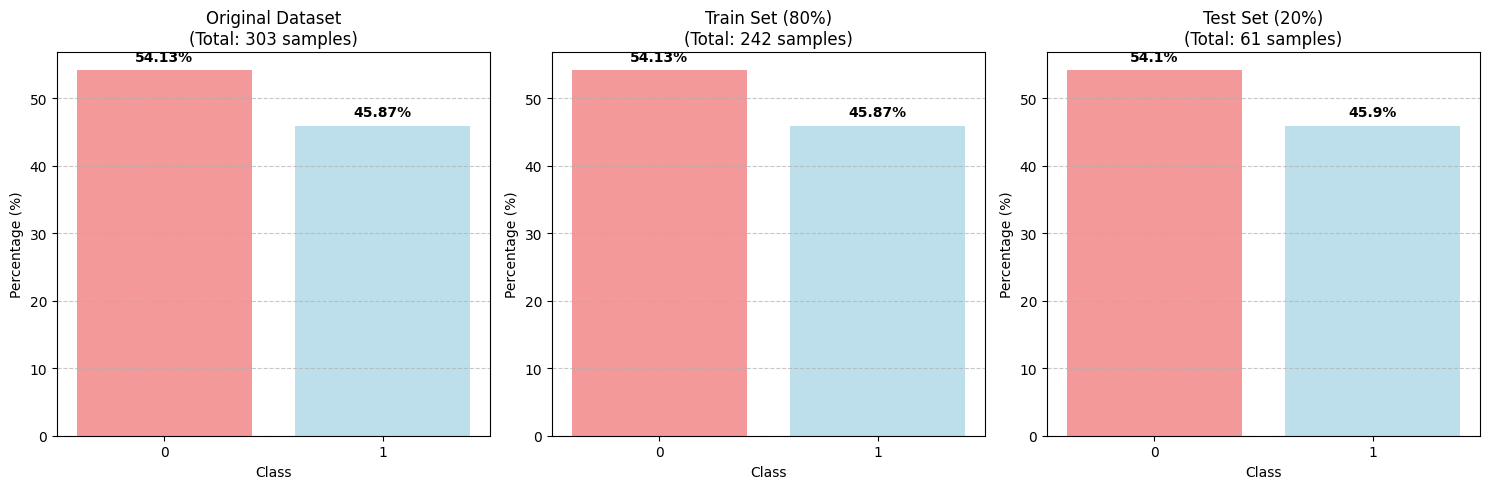

Class Distribution Comparison:


,Class,Original (%),Train (%),Test (%),Original Count,Train Count,Test Count
0,0,54.13,54.13,54.1,164,131,33
1,1,45.87,45.87,45.9,139,111,28



Deviation from Original Distribution:
Class 0:
  Train deviation: +0.00%
  Test deviation:  -0.03%
Class 1:
  Train deviation: +0.00%
  Test deviation:  +0.03%


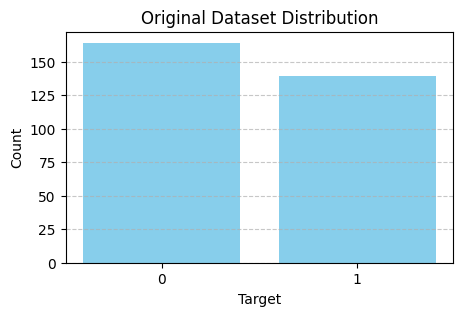

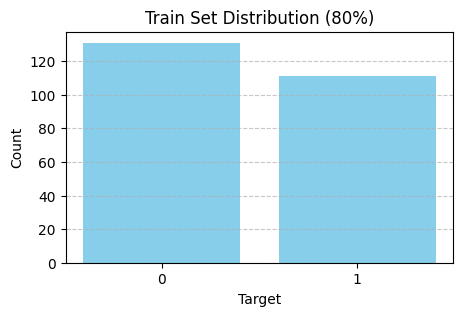

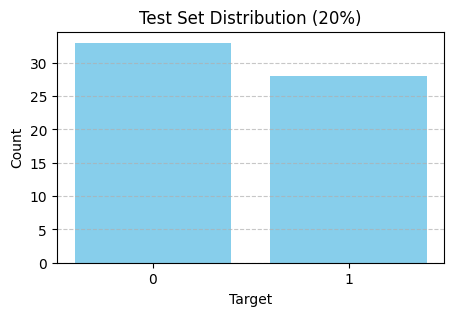

### Test Size 0.2 Classification Report

              precision    recall  f1-score   support

           0       0.86      0.73      0.79        33
           1       0.73      0.86      0.79        28

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



### Test Size 0.2 Confusion Matrix

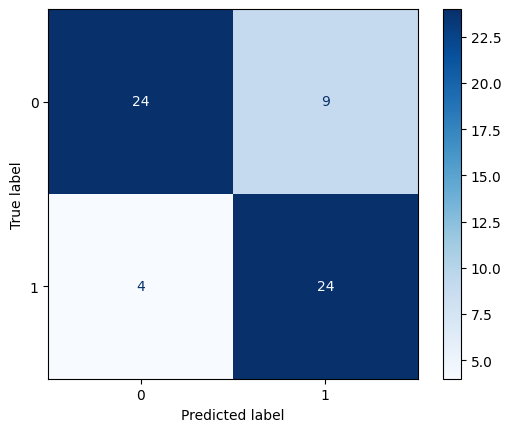

### Test Size 0.2 Decision Tree Visualization (matplotlib)

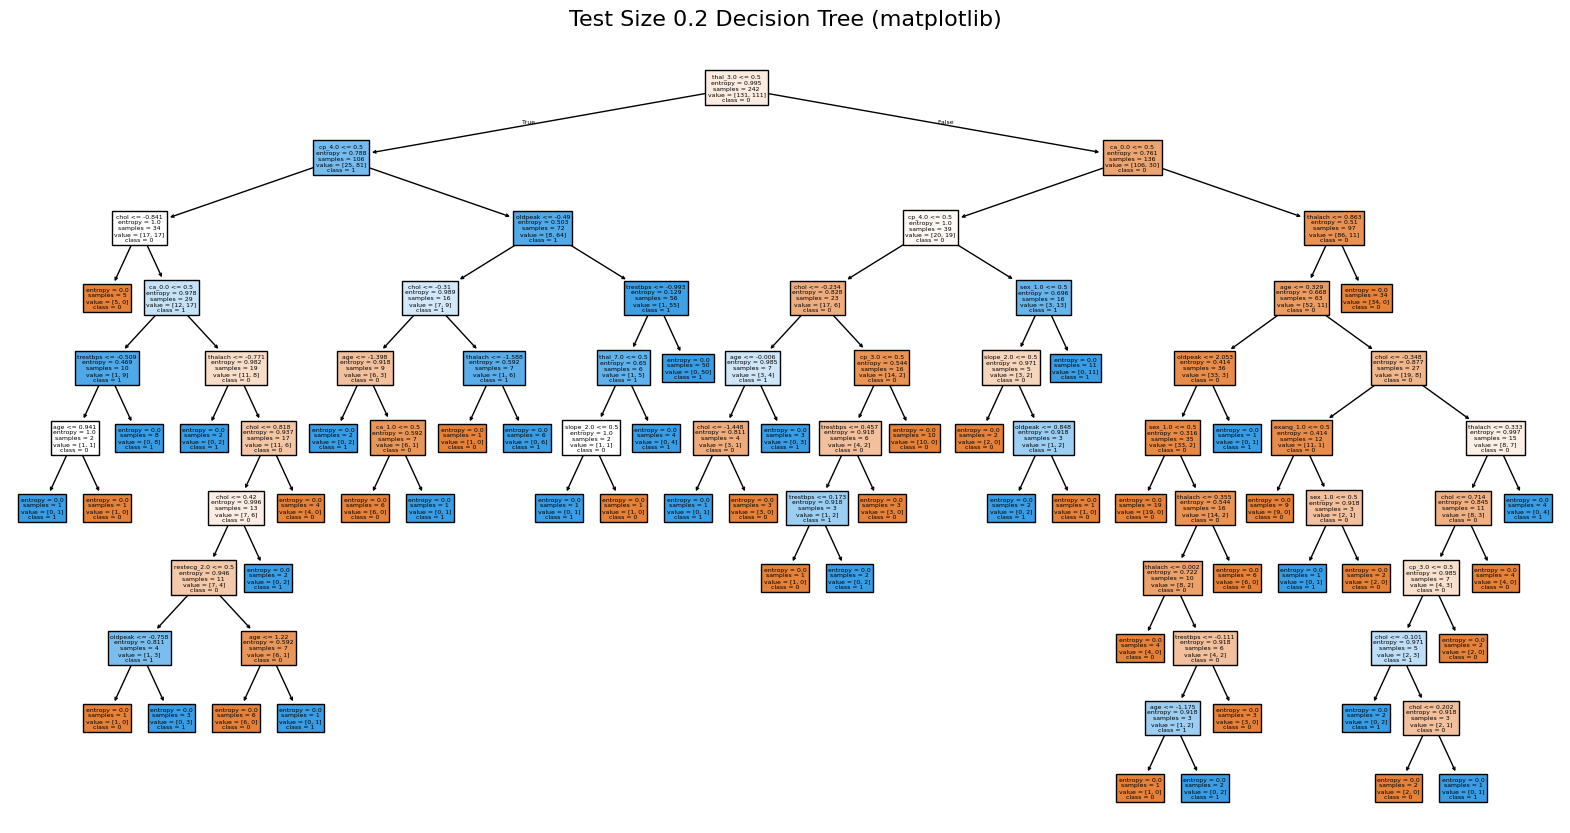

### Test Size 0.2 Decision Tree (Graphviz)

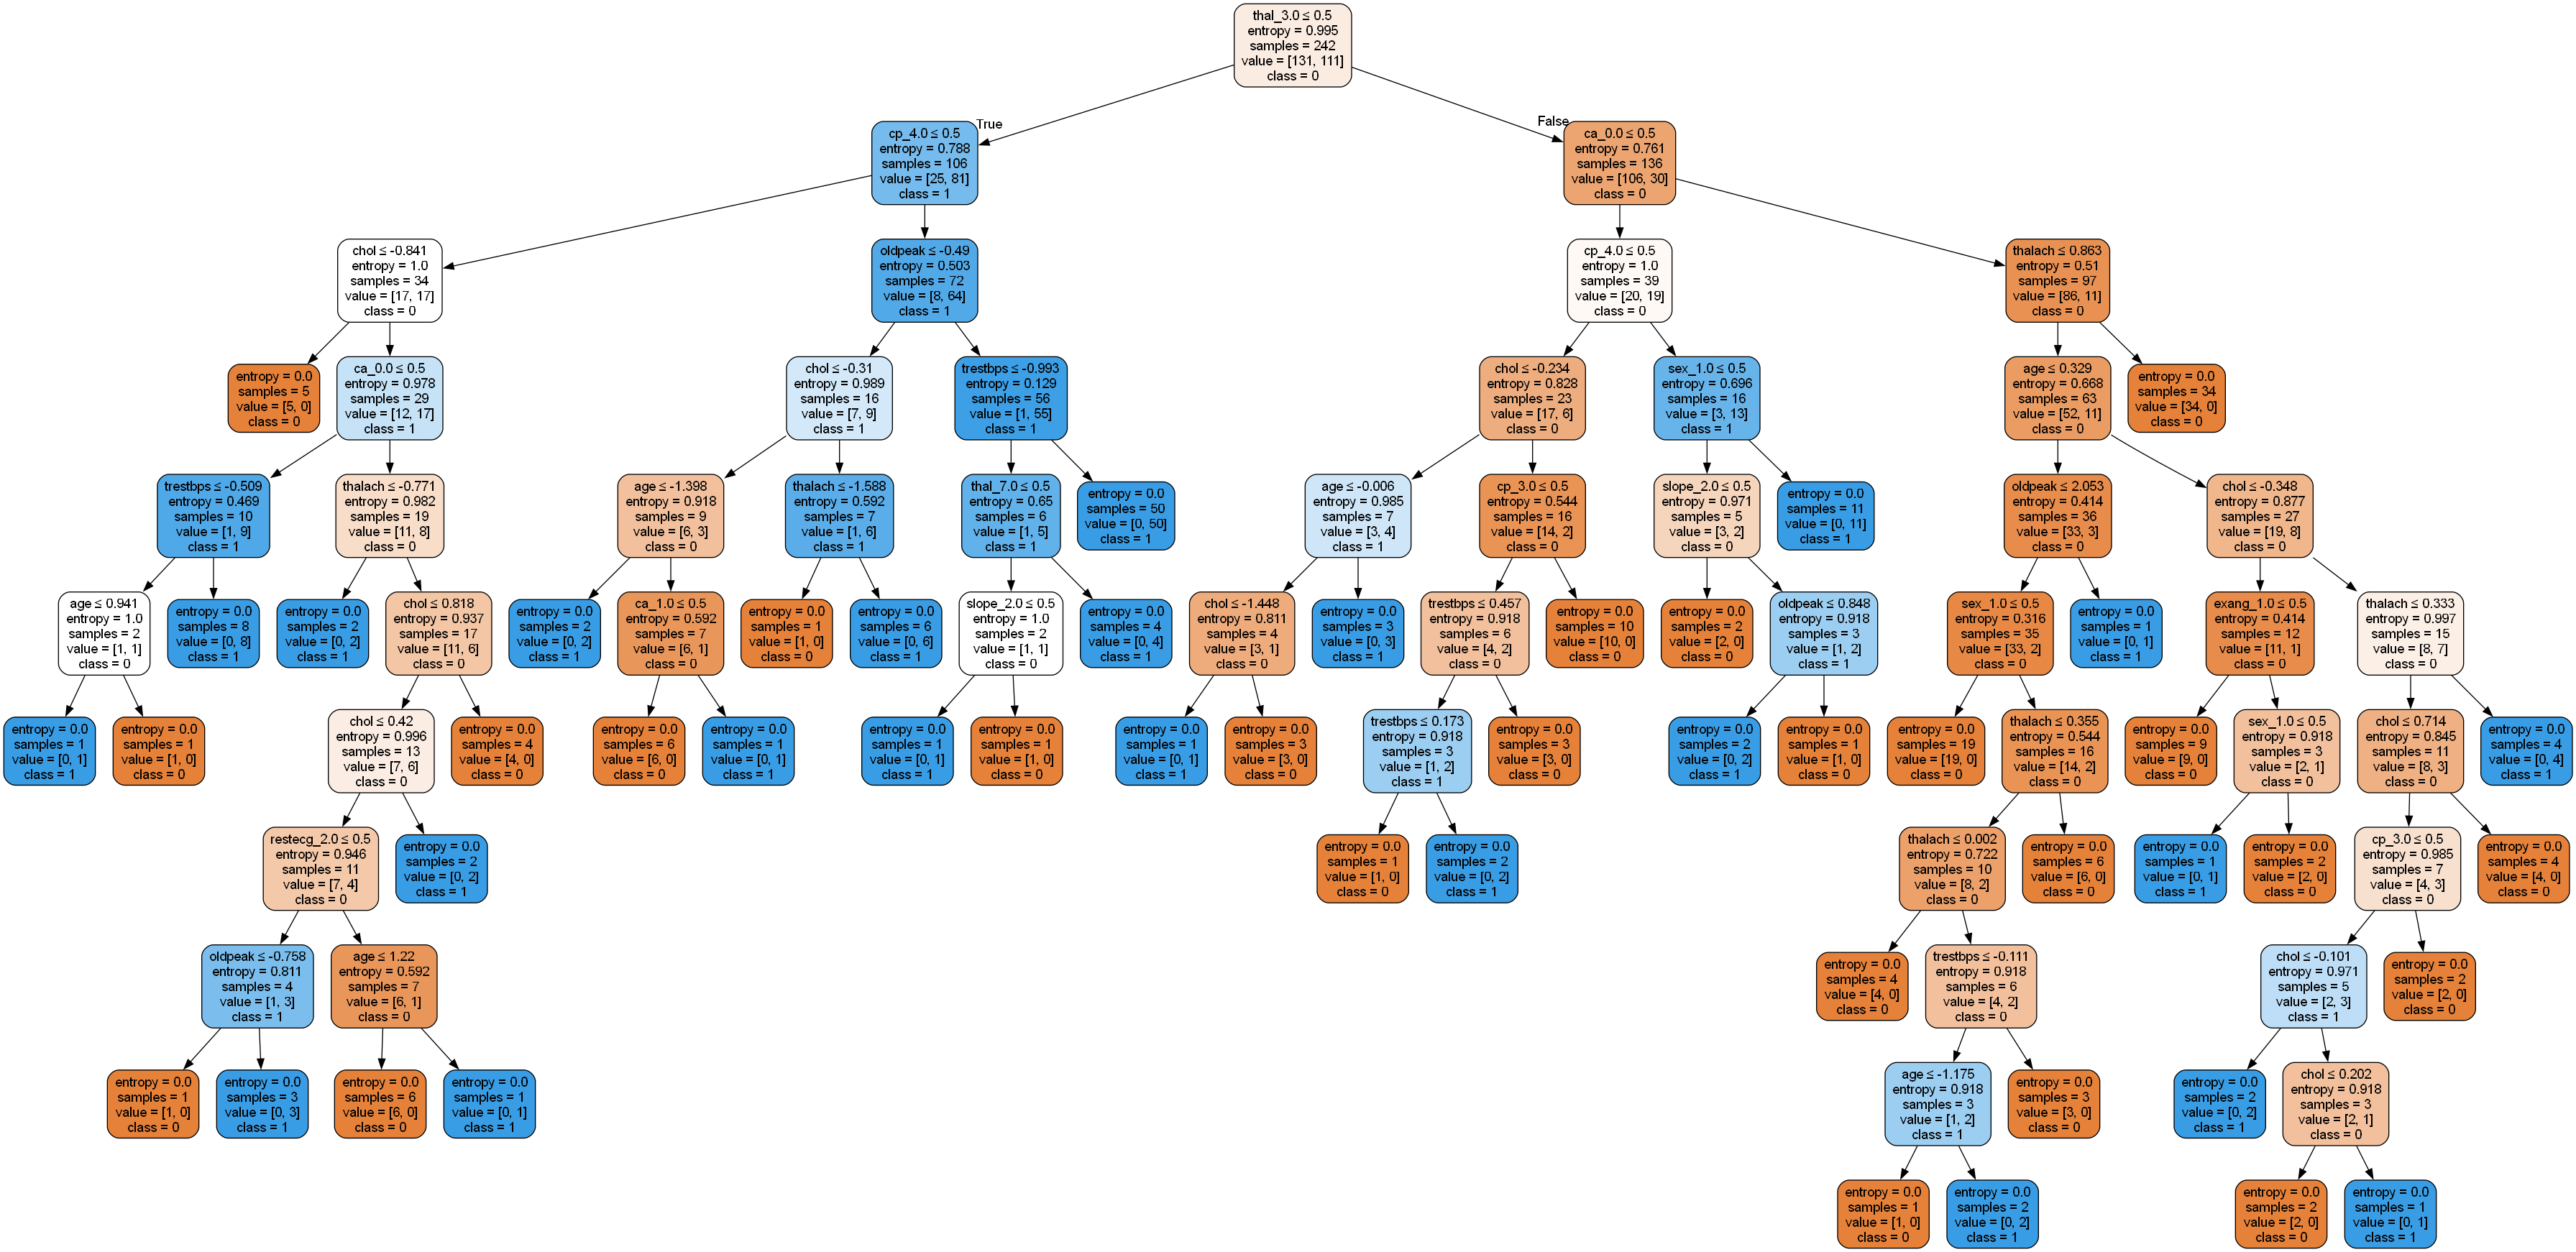

3: Train/Test = 90/10


## Test Size: 0.1

### Class Contribution Analysis

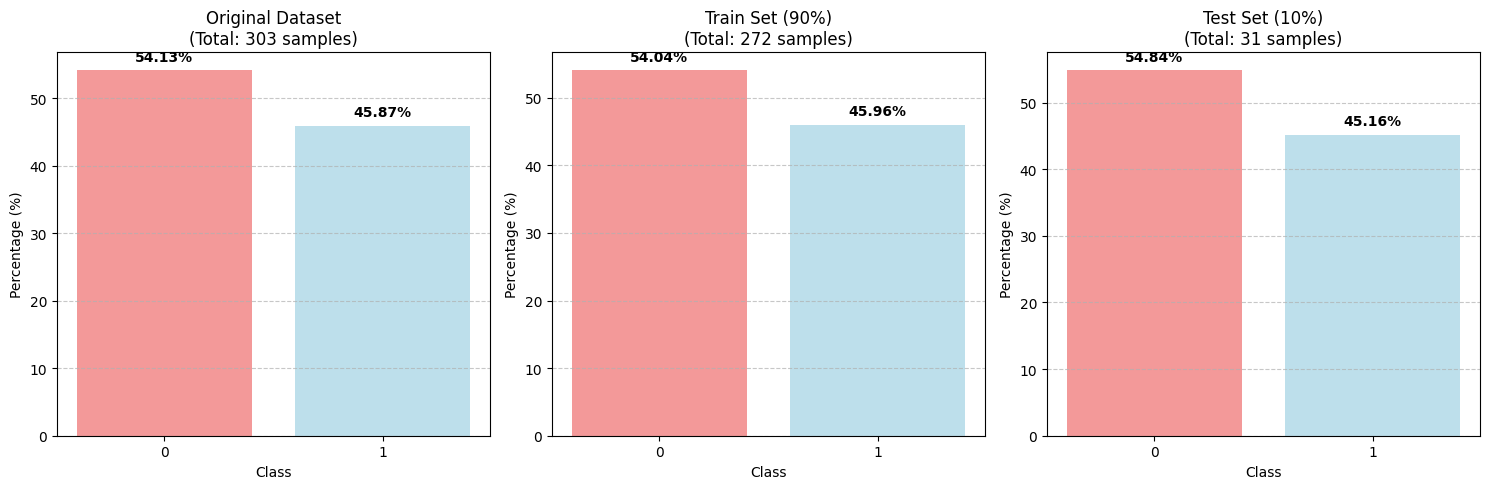

Class Distribution Comparison:


,Class,Original (%),Train (%),Test (%),Original Count,Train Count,Test Count
0,0,54.13,54.04,54.84,164,147,17
1,1,45.87,45.96,45.16,139,125,14



Deviation from Original Distribution:
Class 0:
  Train deviation: -0.09%
  Test deviation:  +0.71%
Class 1:
  Train deviation: +0.09%
  Test deviation:  -0.71%


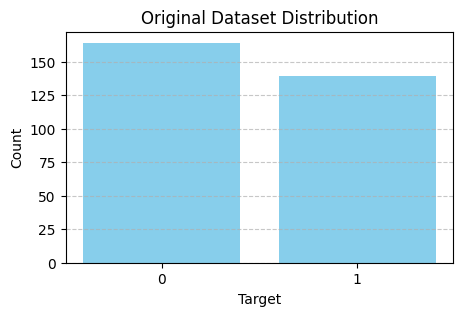

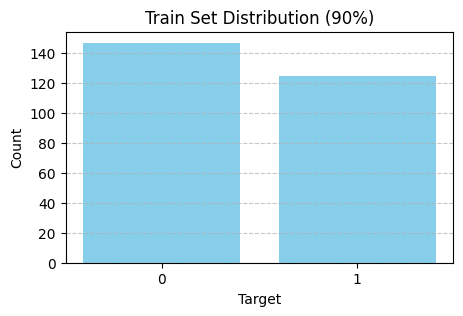

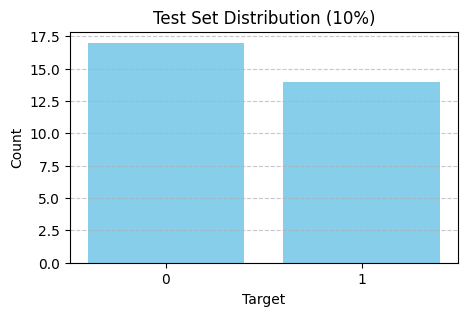

### Test Size 0.1 Classification Report

              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.71      0.86      0.77        14

    accuracy                           0.77        31
   macro avg       0.78      0.78      0.77        31
weighted avg       0.79      0.77      0.77        31



### Test Size 0.1 Confusion Matrix

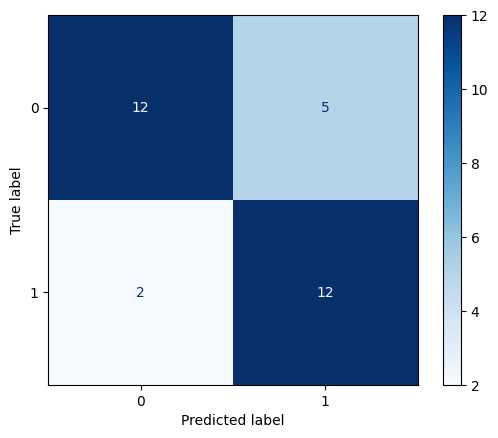

### Test Size 0.1 Decision Tree Visualization (matplotlib)

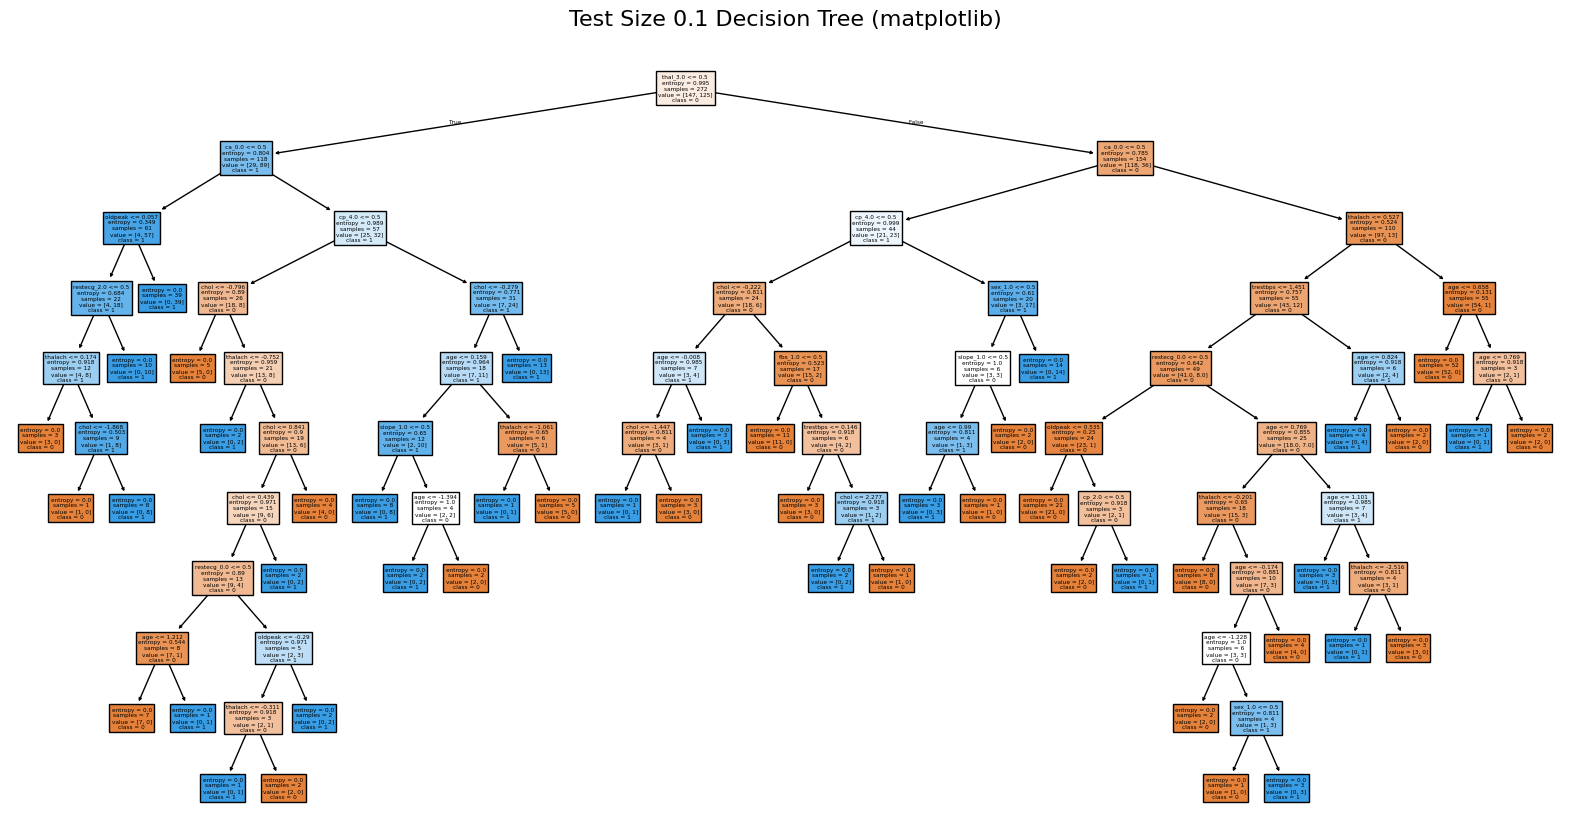

### Test Size 0.1 Decision Tree (Graphviz)

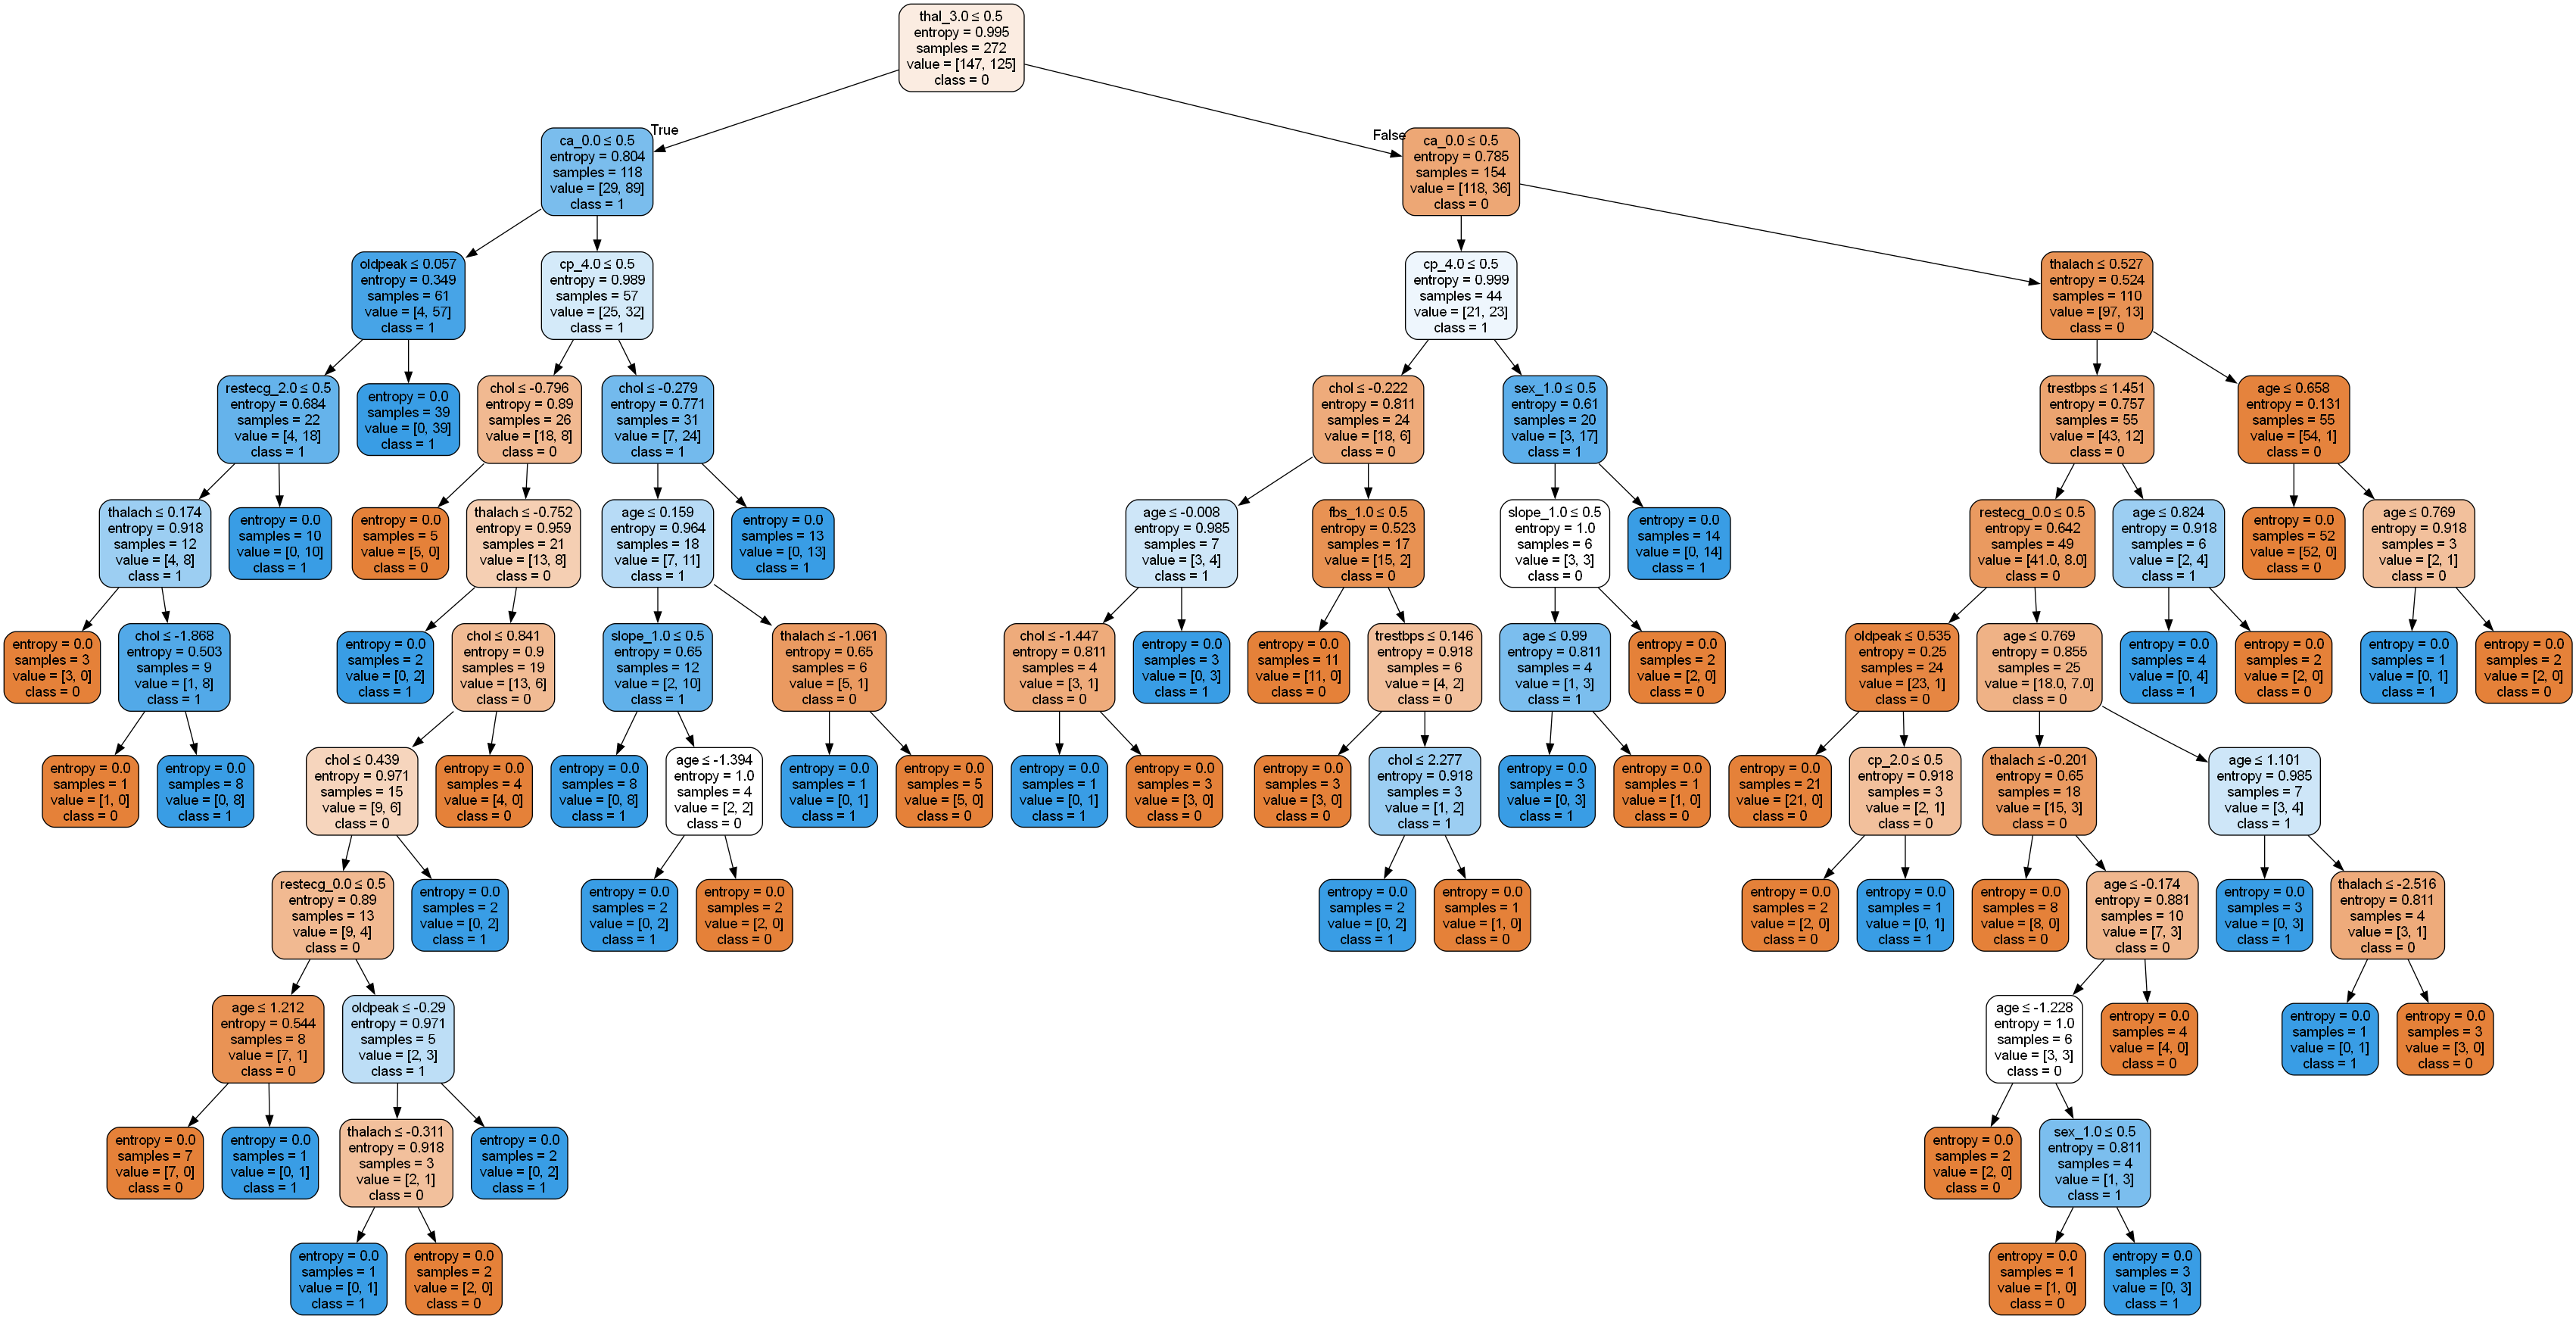

In [27]:
def main():
    """Interactive menu to select experiment mode."""
    df = load_data()
    split_ratios =[0.6, 0.4, 0.2, 0.1]
    for i in range(0,4):
        print(f"{i}: Train/Test = {100 - int(split_ratios[i] * 100)}/{int(split_ratios[i] * 100)}")
        run_experiments(df, test_ratios=[split_ratios[i]])
# Run the main function
main()